# Mount Drive

In [ ]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#%cd /content/gdrive/'My Drive'/'My DeepLearning/
#!unzip 'alien-vs-predator-images.zip'

# Importing Libraries


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
import tensorflow as tf
import PIL

# Importing Dataset and Splitting the Dataset to Traning Set and Validation


In [ ]:
path = "//content//gdrive//My Drive//My DeepLearning//"
import os
os.path.isdir(path)  

True

In [ ]:
path

'//content//gdrive//My Drive//My DeepLearning//'

In [ ]:
# path for Kaggle kernels
input_path = path + "/Alien-vs-Predator-images/"
os.path.isdir(input_path) 

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    input_path + 'validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
conv_base = ResNet50(
    include_top=False, #bo FC trong NN
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False
    #FM ko can train lai 
    #neu OB qua dac biet, khac hoan toan voi ImageNet thi bat True, vd nhu phat hien loi san pham

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)  # buoc nay dung Flatten cung duoc, nhung ngta khuyen cao TransferLearning thi dung GAP
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x) #2 : softmax   #1: sigmoid
model = Model(conv_base.input, predictions)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=347 // 32,  # added in Kaggle
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps=10  # added in Kaggle
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
10/10 [==============================] - 56s 6s/step - loss: 0.3781 - accuracy: 0.8258 - val_loss: 0.3021 - val_accuracy: 0.8750
Epoch 2/3
10/10 [==============================] - 32s 3s/step - loss: 0.1450 - accuracy: 0.9548
Epoch 3/3
10/10 [==============================] - 34s 3s/step - loss: 0.1866 - accuracy: 0.9406


In [ ]:
# save
model.save(path + 'Transfer Learning Models//Alien-vs-Predator-images.h5')

In [ ]:
# load
model = load_model(path + 'Transfer Learning Models//Alien-vs-Predator-images.h5')


In [ ]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg",
                        "validation/predator/3.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [ ]:
img_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=273x184 at 0x7F93366C8748>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=309x163 at 0x7F933448BCF8>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x7F9337C0E630>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=274x184 at 0x7F9337C0E668>]

In [ ]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [ ]:
pred_probs = model.predict(validation_batch)
pred_probs

array([[9.9996853e-01, 3.1427197e-05],
       [9.7716808e-01, 2.2831872e-02],
       [7.2055717e-04, 9.9927944e-01],
       [3.9395946e-04, 9.9960607e-01]], dtype=float32)

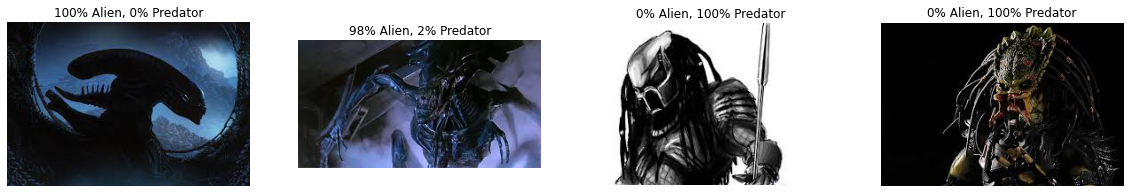

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)